In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import gmsh
import cv2
import scipy
import matplotlib as mpl
import plotly.graph_objs as go
import gmsh
import meshio

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from sklearn.neighbors import KNeighborsClassifier

In [2]:
surfaceID1 = [3]  # Surface with finer mesh
surfaceID2 = [1, 2]  # Surfaces with coarser mesh

gmsh.initialize()
gmsh.open("rectange.geo")  # Replace with your geometry file
gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
# Field 1: Uniform finer mesh size for surface 3
gmsh.model.mesh.field.add("Box", 1)
gmsh.model.mesh.field.setNumber(1, "VIn", 0.1)  # Finer mesh size
# gmsh.model.mesh.field.setNumbers(1, "SurfacesList", surfaceID1)
gmsh.model.mesh.field.setNumber(1, "VOut", 2)  # Finer mesh size
gmsh.model.mesh.field.setNumber(1, "XMax", 100)  # Finer mesh size
gmsh.model.mesh.field.setNumber(1, "XMin", 0)  # Finer mesh size
gmsh.model.mesh.field.setNumber(1, "YMax", 26)  # Finer mesh size
gmsh.model.mesh.field.setNumber(1, "YMin", 24)  # Finer mesh size


# Apply the combined field as a background mesh
gmsh.model.mesh.field.setAsBackgroundMesh(1)

# Generate the 2D mesh
gmsh.model.mesh.generate(2)

# Save the mesh file
mesh_filename = "UniformMesh.msh"
gmsh.write(mesh_filename)
gmsh.finalize()

print(f"Mesh file '{mesh_filename}' created successfully.")


Mesh file 'UniformMesh.msh' created successfully.


In [3]:
# weights and points for Gauss Quadrature 
points = {1:[0] ,2:[1/(3**0.5),-1/(3**0.5)],3:[(3/5)**.5,0,-(3/5)**.5]}
weights = {1:[2],2:[1,1],3:[5/9,8/9,5/9]}
points_2D = {1:[[1/3,1/3]],3:[[1/6,1/6],[2/3,1/6],[1/6,2/3]]}
weights_2D = {1:[.5],3:[1/6,1/6,1/6]}

In [4]:
qo = 1e-3   # W/mm^2
# Cp = 658 #J/kg.K
# rho = 7.6e-6 #kg/mm^3
# kappa = 0.025 #W/mm.K
ro = 2 #mm
vo = 2 #mm/s
Q = 5 #W/mm2

In [5]:
# def rho(T):
#     if T < 100000:                # alpha
#         return (-5.13*10**(-5)*(T**2) - 0.01935*T + 4451)*(10**(-9))
#     elif T < 1878:              #beta
#         return (-2.762**10**(-6)*(T**2) - 0.1663*T + 4468)*(10**(-9))
#     elif T < 1928:              #mushy zone
#         liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
#         return ((-2.762**10**(-6)*(1878**2) - 0.1663*1878 + 4468)*(1-liquidMassToTotalMassRatio) + (-0.565*1928+5093)*(liquidMassToTotalMassRatio))*(10**(-9))
#     else:                       # liquidous
#         return (-0.565*T+5093)*(10**(-9))

# def Cp(T):
#     if T < 100000:                # alpha
#         return 0.25*T+483
#     elif T < 1878:              #beta
#         return 0.14*T+530
#     elif T < 1928:              #mushy zone
#         liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
#         return (0.14*1878+530)*(1-liquidMassToTotalMassRatio) + 930 * liquidMassToTotalMassRatio
#     else:                       # liquidous
#         return 930
    
# def Kappa(T):
#     if T < 100000:                # alpha
#         return (0.012*T+3.3)/1000
#     elif T < 1878:              #beta
#         return (0.016*T-3)/1000
#     elif T < 1928:              #mushy zone
#         liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
#         return ((0.016*1878-3)*(1-liquidMassToTotalMassRatio) + (0.0175*1928-4.5)*liquidMassToTotalMassRatio)/1000
#     else:                       # liquidous
#         return (0.0175*T-4.5)/1000 

In [6]:
def rho(phase,T):
    if phase == 'alpha':                # alpha
        return (-5.13e-5*(T**2)-0.01935*T+4451)*(1e-9)
    elif phase == 'beta':              #beta
        return (-2.762e-6*(T**2)-0.1663*T+4468)*(1e-9)
    elif phase == 'mushy zone':              #mushy zone
        liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
        return ((-2.762**10**(-6)*(1878**2) - 0.1663*1878 + 4468)*(1-liquidMassToTotalMassRatio) + (-0.565*1928+5093)*(liquidMassToTotalMassRatio))*(10**(-9))
    elif phase == 'liquidous':                       # liquidous
        return (-0.565*T+5093)*(10**(-9))

def Cp(phase,T):
    if phase == 'alpha':                # alpha
        return 0.25*T+483
    elif phase == 'beta':              #beta
        return 0.14*T+530
    elif phase == 'mushy zone':              #mushy zone
        liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
        return (0.14*1878+530)*(1-liquidMassToTotalMassRatio) + 930 * liquidMassToTotalMassRatio
    elif phase == 'liquidous':                       # liquidous
        return 930
    
def Kappa(phase,T):
    if phase == 'alpha':                # alpha
        return (0.012*T+3.3)/1000
    elif phase == 'beta':              #beta
        return (0.016*T-3)/1000
    elif phase == 'mushy zone':              #mushy zone
        liquidMassToTotalMassRatio = (T-1878)/(1928-1878)
        return ((0.016*1878-3)*(1-liquidMassToTotalMassRatio) + (0.0175*1928-4.5)*liquidMassToTotalMassRatio)/1000
    elif phase == 'liquidous':                       # liquidous
        return (0.0175*T-4.5)/1000 
    
def whichPhase(T):
    if T < 1268:                # alpha
        return 'alpha'
    elif T < 1928:              #beta
        return 'beta'
    else:                       # liquidous
        return 'liquidous'

In [7]:
def Gaussian(X,sigma,mu):
    return Q*math.exp(-((X-mu) @ (X-mu).T) / (sigma**2))
def NeumannBoundaryCondition(x,y):
    return qo

In [21]:
#################
### Workhorse ###
#################
class RectangularMesh:
    '''Class specific to IITM mesh'''
    def __init__(self, meshFactorForEntireSurface,meshFactorForPatchSurface,geo_file,valuesPrevIteration,valuesPrevStep) -> None:
        self.createMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file=geo_file)
        self.Temperature = (np.ones((1,len(self.coords)))*valuesPrevStep).T
        self.TemperatureForPhaseProperties =  (np.ones((1,len(self.coords)))*valuesPrevIteration).T
        self.M,self.A,self.K,self.S = self.Create_Matrices_2D()
        self.Boundary = self.CreateNeumannBCMAtrix()
           
    def createMesh(self,meshFactorForEntireSurface,meshFactorForPatchSurface,geo_file):
        '''Create Mesh File'''
        import gmsh
        surfaceID = [3]
        gmsh.initialize()
        gmsh.open(geo_file)
        gmsh.option.setNumber("Mesh.MeshSizeFactor", meshFactorForEntireSurface)
        gmsh.model.mesh.field.add("Constant", 1)  # Add a constant field with ID 1
        gmsh.model.mesh.field.setNumber(1, "VIn", meshFactorForPatchSurface)  # Set mesh size factor for Plane 3 to 1
        gmsh.model.mesh.field.setNumbers(1, "SurfacesList", surfaceID)
        gmsh.model.mesh.field.setAsBackgroundMesh(1)
        gmsh.model.mesh.generate(2)
        mesh_filename = 'Rectangular1.msh'
        gmsh.write(mesh_filename)
        gmsh.finalize()
        self.mshInfo(meshInfo=mesh_filename)

    def mshInfo(self,meshInfo):
        '''extracing mesh info from mesh file'''
        import gmsh
        gmsh.initialize()
        #inorder to read the .msh file replace string "IITM_MAP_coarse.msh" with the address of IITM_MAP_coarse.msh
        'Change the location correwspondingly'
        gmsh.open('rectangle_2.msh')
        # Extracting nodes from msh file
        nodeTags,coords,parametricCoord = gmsh.model.mesh.getNodes(-1)     
        coords = coords.reshape((-1,3))
        self.coords = coords[:,:2]
        # Extracting boundary mesh elements from msh file
        _, self.linearNodesTags = gmsh.model.mesh.getElementsByType(1,-1)
        self.linearNodes = np.unique(self.linearNodesTags)
        self.linearNodesTags = self.linearNodesTags.reshape(-1,2)
        # Extracting triangular mesh elements from msh file
        eleTags, triNodesTags = gmsh.model.mesh.getElementsByType(2,-1)
        self.triNodesTags = triNodesTags.reshape((-1,3))
        gmsh.finalize()

    def Create_Matrices_2D(self):
        triNodesTags = self.triNodesTags
        coords = self.coords
        Temp = self.Temperature
        
        # print(coords.shape)
        # print(coords[0])
        n = len(coords)
        gaussPoints = 3
        sigma = ro
        mu = np.array([50,25])
        A = np.zeros((n,n))
        M = np.zeros((n,n))
        K = np.zeros((n,n))
        F = np.zeros((n,1))
        for ele in range(len(triNodesTags)):
            dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
            coordinates = (coords[triNodesTags[ele]-1].T).copy()           #coordinates is dim * no. of points matrix
            Temperature = (Temp[triNodesTags[ele]-1].reshape(-1,1)).copy()
            if np.linalg.det(coordinates @ dN) < 0 :
                triNodesTags[ele][[0,1]] = triNodesTags[ele][[1,0]]
            coordinates = (coords[triNodesTags[ele]-1].T).copy()           #coordinates is dim * no. of points matrix
            Temperature = (Temp[triNodesTags[ele]-1].reshape(-1,1)).copy()
            phaseOfElement = whichPhase(T = np.mean(self.TemperatureForPhaseProperties[triNodesTags[ele]-1]))
            rho_cp_element = 1
            for gpts in range(gaussPoints):
                pt = points_2D[gaussPoints][gpts]
                N = np.array([1-pt[0]-pt[1], pt[0], pt[1]]).reshape(1,-1)
                dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
                k_element = Kappa(phaseOfElement,T=(N@Temperature)[0][0])                          # thermal conductivity
                rho_cp = rho(phaseOfElement,T=(N@Temperature)[0][0]) * Cp(phaseOfElement,T=(N@Temperature)[0][0])     # density * heat capacity         
                Jac_T = coordinates @ dN
                Jac_T_inv = np.linalg.inv(Jac_T)
                det_jac = np.linalg.det(Jac_T)
                m = (N.T@N)*det_jac*weights_2D[gaussPoints][gpts]*rho_cp_element
                # print((Jac_T_inv@dN).shape)
                temp = (dN@Jac_T_inv)[:,0].reshape(-1,1)
                k = rho_cp*vo*(N.T@temp.T)*det_jac*weights_2D[gaussPoints][gpts]
                if det_jac < 0:
                    print('fv')
                a = (dN@Jac_T_inv)@((dN@Jac_T_inv).T)*det_jac*weights_2D[gaussPoints][gpts]*k_element
                X = (coordinates @ N.T).reshape(-1)
                # print([triNodesTags[ele]-1])
                f = N.T*Gaussian(X,sigma,mu)*det_jac*weights_2D[gaussPoints][gpts]
                K[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += k
                M[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += m
                A[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += a
                F[triNodesTags[ele]-1] += f.reshape(-1,1)
        return M,A,K,F
    
    def CreateNeumannBCMAtrix(self):
        linearNodes = self.linearNodesTags
        coords = self.coords
        # print(coords.shape)
        n = self.S.shape[0]
        Boundary = np.zeros((n,1))
        gaussPoints = 3
        for ele in range(len(linearNodes)):
            dN = np.array([-0.5,0.5]).T
            coordinates = coords[linearNodes[ele]-1].T 
            det_Jac = np.linalg.norm(coordinates@dN)
            if(coordinates[0,1]==0 and coordinates[0,0]==0):
                continue
            for pt in range(gaussPoints):
                N = np.array([(1-points[gaussPoints][pt])/2,(1+points[gaussPoints][pt])/2]).reshape(1,-1)
                dN = np.array([-0.5,0.5]).T
                Jac_T = coordinates@dN
                det_Jac = np.linalg.norm(Jac_T)
                x = N@coordinates[0,:]
                # print(x)
                y = N@coordinates[1,:]
                b = N.T*NeumannBoundaryCondition(x[0],y[0])*weights[gaussPoints][pt]*det_Jac
                Boundary[linearNodes[ele]-1] += b
        return Boundary

In [15]:
# Taking phase change into consideration
#################
### Workhorse ###
#################
class RectangularMeshInvolvingPhaseChange:
    '''Class specific to IITM mesh'''
    def __init__(self, meshFactorForEntireSurface,meshFactorForPatchSurface,geo_file,valuesPrevIteration,valuesPrevStep,xDisplacementOfSource) -> None:
        self.createMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file=geo_file)
        self.Temperature = (np.ones((1,len(self.coords)))*valuesPrevStep).T
        self.TemperatureForPhaseProperties =  (np.ones((1,len(self.coords)))*valuesPrevIteration).T
        self.mu = np.array([xDisplacementOfSource,25])
        self.M,self.A,self.K,self.S = self.Create_Matrices_2D()
        self.Boundary = self.CreateNeumannBCMAtrix()
           
    def createMesh(self,meshFactorForEntireSurface,meshFactorForPatchSurface,geo_file):
        '''Create Mesh File'''
        import gmsh
        gmsh.initialize()
        gmsh.open(geo_file)  # Replace with your geometry file
        gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
        gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
        # Field 1: Uniform finer mesh size for surface 3
        gmsh.model.mesh.field.add("Box", 1)
        gmsh.model.mesh.field.setNumber(1, "VIn", meshFactorForPatchSurface)  # Finer mesh size
        # gmsh.model.mesh.field.setNumbers(1, "SurfacesList", surfaceID1)
        gmsh.model.mesh.field.setNumber(1, "VOut", meshFactorForEntireSurface)  # Finer mesh size
        gmsh.model.mesh.field.setNumber(1, "XMax", 100)  # Finer mesh size
        gmsh.model.mesh.field.setNumber(1, "XMin", 0)  # Finer mesh size
        gmsh.model.mesh.field.setNumber(1, "YMax", 26)  # Finer mesh size
        gmsh.model.mesh.field.setNumber(1, "YMin", 24)  # Finer mesh size


        # Apply the combined field as a background mesh
        gmsh.model.mesh.field.setAsBackgroundMesh(1)

        # Generate the 2D mesh
        gmsh.model.mesh.generate(2)

        # Save the mesh file
        mesh_filename = "Rectangular.msh"
        gmsh.write(mesh_filename)
        gmsh.finalize()

        self.mshInfo(meshInfo=mesh_filename)

    def mshInfo(self,meshInfo):
        '''extracing mesh info from mesh file'''
        import gmsh
        gmsh.initialize()
        #inorder to read the .msh file replace string "IITM_MAP_coarse.msh" with the address of IITM_MAP_coarse.msh
        'Change the location correwspondingly'
        gmsh.open(meshInfo)
        # Extracting nodes from msh file
        nodeTags,coords,parametricCoord = gmsh.model.mesh.getNodes(-1)
        coords = coords.reshape((-1,3))
        self.coords = coords[:,:2]
        # Extracting boundary mesh elements from msh file
        _, self.linearNodesTags = gmsh.model.mesh.getElementsByType(1,-1)
        self.linearNodes = np.unique(self.linearNodesTags)
        self.linearNodesTags = self.linearNodesTags.reshape(-1,2)
        # Extracting triangular mesh elements from msh file
        eleTags, triNodesTags = gmsh.model.mesh.getElementsByType(2,-1)
        self.triNodesTags = triNodesTags.reshape((-1,3))
        gmsh.finalize()

    def Create_Matrices_2D(self):
        triNodesTags = self.triNodesTags
        coords = self.coords
        Temp = self.Temperature
        TemperatureForPhaseProperties = self.TemperatureForPhaseProperties.copy()
        # print(coords.shape)
        # print(coords[0])
        n = len(coords)
        gaussPoints = 3
        sigma = ro
        mu = self.mu
        A = np.zeros((n,n))
        M = np.zeros((n,n))
        K = np.zeros((n,n))
        F = np.zeros((n,1))
        for ele in range(len(triNodesTags)):
            dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
            N = np.array([1/3, 1/3, 1/3]).reshape(1,-1)
            coordinates = (coords[triNodesTags[ele]-1].T).copy()           #coordinates is dim * no. of points matrix
            if np.linalg.det(coordinates @ dN) < 0 :
                triNodesTags[ele][[0,1]] = triNodesTags[ele][[1,0]]
            coordinates = (coords[triNodesTags[ele]-1].T).copy()           #coordinates is dim * no. of points matrix
            Temperature = (Temp[triNodesTags[ele]-1].reshape(-1,1)).copy()
            phaseOfElement = whichPhase(T = np.mean(TemperatureForPhaseProperties[triNodesTags[ele]-1]))
            for gpts in range(gaussPoints):
                pt = points_2D[gaussPoints][gpts]
                N = np.array([1-pt[0]-pt[1], pt[0], pt[1]]).reshape(1,-1)
                dN = np.array([[-1,1,0],[-1,0,1]]).T        #grad phi
                Jac_T = coordinates @ dN
                Jac_T_inv = np.linalg.inv(Jac_T)
                det_jac = np.linalg.det(Jac_T)
                k_element = Kappa(phase=phaseOfElement,T=(N@Temperature)[0][0])                          # thermal conductivity
                rho_cp = rho(phase=phaseOfElement,T=(N@Temperature)[0][0]) * Cp(phase=phaseOfElement,T=(N@Temperature)[0][0])     # density * heat capacity         
                m = (N.T@N)*det_jac*weights_2D[gaussPoints][gpts]*rho_cp
                temp = (dN@Jac_T_inv)[:,0].reshape(-1,1)
                k = rho_cp*vo*(N.T@temp.T)*det_jac*weights_2D[gaussPoints][gpts]
                a = (dN@Jac_T_inv)@((dN@Jac_T_inv).T)*det_jac*weights_2D[gaussPoints][gpts]*k_element
                X = (coordinates @ N.T).reshape(-1)
                f = N.T*Gaussian(X,sigma,mu)*det_jac*weights_2D[gaussPoints][gpts]
                K[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += k
                M[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += m
                A[np.ix_(triNodesTags[ele]-1,triNodesTags[ele]-1)] += a
                F[triNodesTags[ele]-1] += f.reshape(-1,1)
        return M,A,K,F
    
    def CreateNeumannBCMAtrix(self):
        linearNodes = self.linearNodesTags
        coords = self.coords
        # print(coords.shape)
        n = self.S.shape[0]
        Boundary = np.zeros((n,1))
        gaussPoints = 3
        for ele in range(len(linearNodes)):
            coordinates = coords[linearNodes[ele]-1].T 
            for pt in range(len(points[gaussPoints])):
                N = np.array([(1-points[gaussPoints][pt])/2,(1+points[gaussPoints][pt])/2]).reshape(1,-1)
                dN = np.array([-0.5,0.5]).T
                Jac_T = coordinates@dN
                det_Jac = np.linalg.norm(Jac_T)
                x = N@coordinates[0,:]
                y = N@coordinates[1,:]
                b = N.T*NeumannBoundaryCondition(x[0],y[0])*weights[gaussPoints][pt]*det_Jac
                Boundary[linearNodes[ele]-1] += b
        return Boundary

## Picard iteration for moving source heat conduction

In [22]:
def PicardIteration(meshFactorForEntireSurface,meshFactorForPatchSurface):
    '''Function to perform Picard Iteration'''

    ## Initialisation
    tol = 4*1e-5
    it = 0
    dirichiletBoundaryTemperature = 20+273
    mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',valuesPrevStep=dirichiletBoundaryTemperature,valuesPrevIteration=dirichiletBoundaryTemperature)
    T_old = mesh.Temperature
    T_prev_iter = mesh.Temperature
    T_prev_iter[np.where(mesh.coords[:,0] >= 45)] = T_prev_iter[np.where(mesh.coords[:,0] >= 45)] +000
    TT = T_prev_iter.copy()
    coords = mesh.coords
    dirichiletBoundary = np.where(coords[:,0] == 0)[0]
    n = coords.shape[0]
    nodes = np.arange(n)
    interiorNodes = np.delete(nodes,dirichiletBoundary)

    ##Workhorse of Picard 
    while(it<=1):       ##Preventing infinite loop
        it += 1
        mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',valuesPrevStep=T_old.T,valuesPrevIteration=T_prev_iter.T)
        A,K,S,Boundary = mesh.A,mesh.K,mesh.S,mesh.Boundary
        T_new = np.ones((n,1))*dirichiletBoundaryTemperature
        F = (A+K)[np.ix_(interiorNodes,interiorNodes)]
        T_new[interiorNodes] = np.linalg.pinv(F)@((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])
        print('Error after iteration '+str(it)+' is '+str(np.linalg.norm(T_old-T_new)))
        if np.linalg.norm(T_old-T_new)<tol:     #Terminating condition
            break
        T_old = T_new
    return T_new,mesh
    # return mesh

In [23]:
TT,mesh = PicardIteration(10,10)

Error after iteration 1 is 9691.224339952465
Error after iteration 2 is 2087.470343275978


In [24]:
np.sum(mesh.Boundary)

0.25000000000000006

In [27]:
# np.max(t)

In [28]:
# plt.figure(figsize=(8,4))
# plt.tricontourf(mesh.coords[:, 0], mesh.coords[:, 1],t.reshape(-1),cmap='jet')
# plt.colorbar()
# plt.show()

In [29]:
def PicardIterationRevised(meshFactorForEntireSurface,meshFactorForPatchSurface):
    '''Function to perform Picard Iteration'''

    ## Initialisation
    tol = 4*1e-5
    it = 0
    dirichiletBoundaryTemperature = 20+273
    mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',valuesPrevStep=dirichiletBoundaryTemperature,valuesPrevIteration=dirichiletBoundaryTemperature)
    T_old = mesh.Temperature
    T_prev_iter = mesh.Temperature
    coords = mesh.coords
    dirichiletBoundary = np.where(coords[:,0] == 0)[0]
    n = coords.shape[0]
    nodes = np.arange(n)
    interiorNodes = np.delete(nodes,dirichiletBoundary)
    
    ##Workhorse of Picard 
    while(it<40):       ##Preventing infinite loop
        it += 1
        mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',valuesPrevStep=T_old.T,valuesPrevIteration=T_prev_iter.T)
        A,K,S,Boundary = mesh.A,mesh.K,mesh.S,mesh.Boundary
        T_new = np.ones((n,1))*dirichiletBoundaryTemperature
        F = (A+K)[np.ix_(interiorNodes,interiorNodes)]
        T_new[interiorNodes] = np.linalg.pinv(F)@((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])
        print('Error after iteration '+str(it)+' is '+str(np.linalg.norm(T_old-T_new)))
        if np.linalg.norm(T_old-T_new)<tol:     #Terminating condition
            break
        T_old = T_new
    return T_new,mesh
    # return mesh

In [30]:
def PicardIterationSparse(meshFactorForEntireSurface,meshFactorForPatchSurface):
    '''Function to perform Picard Iteration'''

    ## Initialisation
    tol = 4*1e-5
    it = 0
    dirichiletBoundaryTemperature = 20+273
    mesh = RectangularMesh(
        meshFactorForEntireSurface=meshFactorForEntireSurface,
        meshFactorForPatchSurface=meshFactorForPatchSurface,
        geo_file='rectange.geo',
        values=dirichiletBoundaryTemperature
    )
    T_old = mesh.Temperature
    coords = mesh.coords
    dirichiletBoundary = np.where(coords[:,0] == 0)[0]
    n = coords.shape[0]
    nodes = np.arange(n)
    interiorNodes = np.delete(nodes,dirichiletBoundary)

    ##Workhorse of Picard 
    while(it<40):       ##Preventing infinite loop
        it += 1
        mesh = RectangularMesh(meshFactorForEntireSurface=meshFactorForEntireSurface,meshFactorForPatchSurface=meshFactorForPatchSurface,geo_file='rectange.geo',values=T_old.T)
        A_sparse = csr_matrix(mesh.A)
        K_sparse = csr_matrix(mesh.K)
        S_sparse = csr_matrix(mesh.S)
        Boundary_sparse = csr_matrix(mesh.Boundary)
        T_new = np.ones((n, 1)) * dirichiletBoundaryTemperature

        # Compute the combined sparse matrix F
        F_sparse = (A_sparse + K_sparse)[np.ix_(interiorNodes, interiorNodes)]

        # Compute the right-hand side for the sparse system
        rhs = (
            S_sparse + Boundary_sparse
            - (A_sparse + K_sparse)[:, dirichiletBoundary] @ 
            (dirichiletBoundaryTemperature * np.ones((len(dirichiletBoundary), 1)))
        )
        rhs_interior = rhs[interiorNodes]

        # Solve for T_new at interior nodes using the sparse solver
        T_new[interiorNodes] = spsolve(F_sparse, rhs_interior).reshape(-1,1)
        T_new_dense = T_new.toarray() if isinstance(T_new, csr_matrix) else T_new
        print('Error after iteration '+str(it)+' is '+str(np.linalg.norm(T_old-T_new_dense)))
        if np.linalg.norm(T_old-T_new_dense)<tol:     #Terminating condition
            break
        T_old = T_new_dense
    return T_new_dense,mesh
    # return mesh

In [ ]:
mesh_sizes = []

In [31]:
def PicardIterationSparseForMovingSource(meshFactorForEntireSurface,meshFactorForPatchSurface):
    '''Function to perform Picard Iteration'''

    ## Initialisation
    L = 100
    T = int(abs(L/vo))
    steps = 10
    delta_t = T/steps
    tol = 4*1e-5
    dirichiletBoundaryTemperature = 20+273
    mesh = RectangularMeshInvolvingPhaseChange(
                meshFactorForEntireSurface=meshFactorForEntireSurface,
                meshFactorForPatchSurface=meshFactorForPatchSurface,
                valuesPrevStep=dirichiletBoundaryTemperature,
                valuesPrevIteration=dirichiletBoundaryTemperature,
                geo_file='rectange.geo',
                xDisplacementOfSource = 0
            )    
    T_old = mesh.Temperature
    coords = mesh.coords
    dirichiletBoundary = np.where(coords[:,0] == 0)[0]
    n = coords.shape[0]
    Temperatures = np.ones((steps+1,n))*dirichiletBoundaryTemperature
    nodes = np.arange(n)
    interiorNodes = np.delete(nodes,dirichiletBoundary)
    print(mesh.coords.shape)
    print(mesh.triNodesTags.shape)
    ##Workhorse of Picard 
    for timestep in range(1,steps+1):
        it = 0
        T_old = Temperatures[timestep-1,:].reshape(-1,1) + 1200
        while(it<40):       ##Preventing infinite loop
            it += 1
            mesh = RectangularMeshInvolvingPhaseChange(
                meshFactorForEntireSurface=meshFactorForEntireSurface,
                meshFactorForPatchSurface=meshFactorForPatchSurface,
                valuesPrevStep=T_old.T,
                valuesPrevIteration=Temperatures[timestep-1,:].reshape(1,-1),
                geo_file='rectange.geo',
                xDisplacementOfSource = timestep*vo
            )
            A_sparse = csr_matrix(mesh.A)
            K_sparse = csr_matrix(mesh.K)
            S_sparse = csr_matrix(mesh.S)
            Boundary_sparse = csr_matrix(mesh.Boundary)
            T_new = np.ones((n, 1)) * dirichiletBoundaryTemperature

            # Compute the combined sparse matrix F
            F_sparse = (A_sparse + K_sparse)[np.ix_(interiorNodes, interiorNodes)]

            # Compute the right-hand side for the sparse system
            rhs = (
                S_sparse + Boundary_sparse
                - (A_sparse + K_sparse)[:, dirichiletBoundary] @ 
                (dirichiletBoundaryTemperature * np.ones((len(dirichiletBoundary), 1)))
            )
            rhs_interior = rhs[interiorNodes]

            # Solve for T_new at interior nodes using the sparse solver
            T_new[interiorNodes] = spsolve(F_sparse, rhs_interior).reshape(-1,1)
            T_new_dense = T_new.toarray() if isinstance(T_new, csr_matrix) else T_new
            print('Error after iteration '+str(it)+' is '+str(np.linalg.norm(T_old-T_new_dense)))
            if np.linalg.norm(T_old-T_new_dense)<tol:     #Terminating condition
                break
            T_old = T_new_dense
        print('Time Step '+str(timestep))
        print('Sum of K ele '+str(np.sum(mesh.A)))
        print('Sum of G ele '+str(np.sum(mesh.K)))
        print('Sum of F ele '+str(np.sum(mesh.S)))
        print('Sum of Bc ele '+str(np.sum(mesh.Boundary)))
        scatter = plt.scatter(mesh.coords[:, 0], mesh.coords[:, 1], c=T_new_dense, cmap='jet', s=1, edgecolor=None)
        plt.legend()
        plt.colorbar(scatter, label='Value')
        plt.show()
        Temperatures[timestep,:] = T_new_dense.reshape(-1)
        print(np.max(Temperatures[timestep,:]))
    return Temperatures,mesh
    # return mesh

In [40]:
mesh.coords.shape

(2619, 2)

(2619, 2)
(5116, 3)
Error after iteration 1 is 55684.74421403193
Error after iteration 2 is 9010.54996458484
Error after iteration 3 is 2021.4804525347765
Error after iteration 4 is 221.31778408770236
Error after iteration 5 is 19.407846726884735
Error after iteration 6 is 2.896601077963217
Error after iteration 7 is 0.5345312771869007
Error after iteration 8 is 0.060697034293539266
Error after iteration 9 is 0.00557313755972534
Error after iteration 10 is 0.0010534300894463888
Error after iteration 11 is 0.00016189658560205114
Error after iteration 12 is 1.5983437638705893e-05
Time Step 1
Sum of K ele 5.152128723651117e-16
Sum of G ele -4.369334755116583e-17
Sum of F ele 57.88595739928213
Sum of Bc ele 0.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


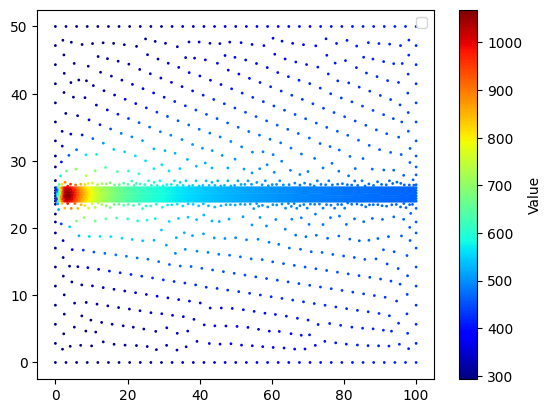

1068.8133039249503
Error after iteration 1 is 65649.65271281534
Error after iteration 2 is 11887.765342787005
Error after iteration 3 is 2455.9093127894434
Error after iteration 4 is 218.68510898613536
Error after iteration 5 is 40.24308593357226
Error after iteration 6 is 4.83790580058827
Error after iteration 7 is 0.6823040201462598
Error after iteration 8 is 0.13451953688227405
Error after iteration 9 is 0.01323685664848294
Error after iteration 10 is 0.0028585814772072297
Error after iteration 11 is 0.00039952697325871015
Error after iteration 12 is 4.83464322075821e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error after iteration 13 is 1.0472210310724677e-05
Time Step 2
Sum of K ele 1.1188966420050406e-16
Sum of G ele -2.7592945289756088e-17
Sum of F ele 62.71841067385935
Sum of Bc ele 0.5


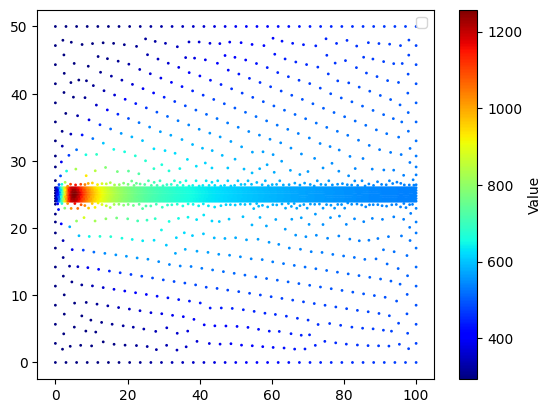

1256.9580319175755
Error after iteration 1 is 68755.0309187673
Error after iteration 2 is 11764.574645929391
Error after iteration 3 is 2087.7392955592404
Error after iteration 4 is 218.05966758314236
Error after iteration 5 is 34.659497478391664
Error after iteration 6 is 3.3940340687400687
Error after iteration 7 is 0.7539201899673119
Error after iteration 8 is 0.06401240967307349
Error after iteration 9 is 0.016066726073078814
Error after iteration 10 is 0.0014144135453046725
Error after iteration 11 is 0.0003324563281076289


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error after iteration 12 is 3.404092566822697e-05
Time Step 3
Sum of K ele 6.756747938929664e-16
Sum of G ele 1.8865117801247777e-17
Sum of F ele 62.8452634127724
Sum of Bc ele 0.5


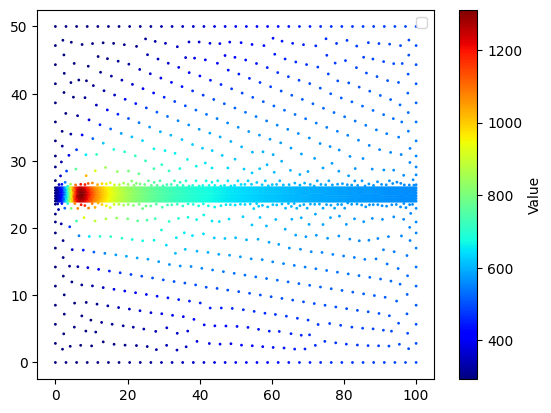

1311.1695905980507
Error after iteration 1 is 69405.72571142769
Error after iteration 2 is 11113.14018725238
Error after iteration 3 is 1764.0471308856788
Error after iteration 4 is 226.9742281845163
Error after iteration 5 is 30.3886302259
Error after iteration 6 is 4.248066858239957
Error after iteration 7 is 0.6786899055279405
Error after iteration 8 is 0.08614111774250043
Error after iteration 9 is 0.015330471050808476
Error after iteration 10 is 0.0018232424571501997
Error after iteration 11 is 0.00034868722859217967


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error after iteration 12 is 3.958252471123672e-05
Time Step 4
Sum of K ele 1.968911145233676e-16
Sum of G ele 2.6617163334519134e-17
Sum of F ele 62.82934206831271
Sum of Bc ele 0.5


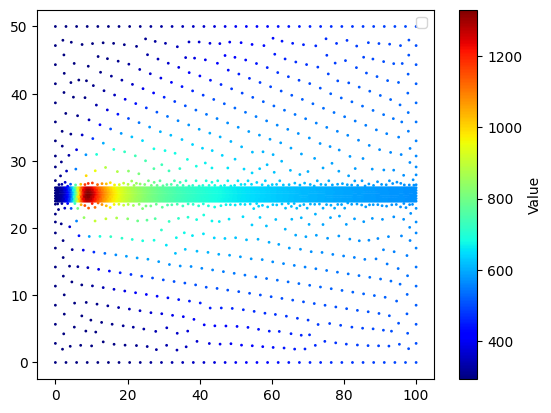

1330.573802796795
Error after iteration 1 is 69382.0050419018
Error after iteration 2 is 10626.885045212519
Error after iteration 3 is 1606.9989752279218
Error after iteration 4 is 225.32782109279051
Error after iteration 5 is 27.997445477292597
Error after iteration 6 is 4.50680783234123
Error after iteration 7 is 0.6304428956325382
Error after iteration 8 is 0.09758854088626227
Error after iteration 9 is 0.014428606596525253
Error after iteration 10 is 0.0022127103068302757
Error after iteration 11 is 0.00033356282704531795
Error after iteration 12 is 5.156104633716829e-05
Error after iteration 13 is 7.753809459944242e-06
Time Step 5
Sum of K ele 7.797582024515748e-16
Sum of G ele 1.5395670849294163e-17
Sum of F ele 62.799441194173895
Sum of Bc ele 0.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


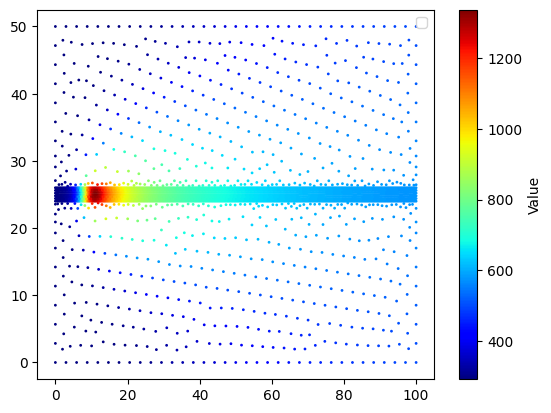

1336.0688674406035
Error after iteration 1 is 69178.70386824787
Error after iteration 2 is 10345.037705678964
Error after iteration 3 is 1526.443727656078
Error after iteration 4 is 220.45404993385318
Error after iteration 5 is 27.01431487376213
Error after iteration 6 is 4.342286789419302
Error after iteration 7 is 0.5984631112781035
Error after iteration 8 is 0.09078227233170473
Error after iteration 9 is 0.013349214058609109
Error after iteration 10 is 0.0019819342983313105
Error after iteration 11 is 0.00029994879463659423
Error after iteration 12 is 4.45452888899224e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error after iteration 13 is 6.773462527984589e-06
Time Step 6
Sum of K ele 8.239936510889834e-17
Sum of G ele -4.85722573273506e-17
Sum of F ele 62.868075267988885
Sum of Bc ele 0.5


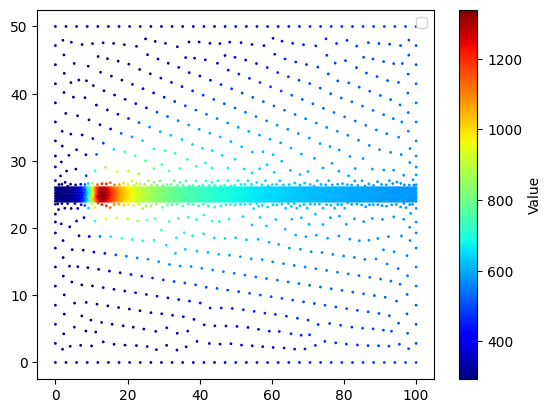

1339.1137393371687
Error after iteration 1 is 69010.22703323791
Error after iteration 2 is 10179.711962295465
Error after iteration 3 is 1481.8289767705764
Error after iteration 4 is 215.80086348195846
Error after iteration 5 is 25.750492509746714
Error after iteration 6 is 4.273617013942672
Error after iteration 7 is 0.5662331416812034
Error after iteration 8 is 0.08939227936576843
Error after iteration 9 is 0.0124899603977561
Error after iteration 10 is 0.0019329296829135145
Error after iteration 11 is 0.0002761251725428867
Error after iteration 12 is 4.2711609513899366e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error after iteration 13 is 6.113247287554133e-06
Time Step 7
Sum of K ele 2.3071822230491534e-16
Sum of G ele -5.1120132432691534e-17
Sum of F ele 62.87413356065039
Sum of Bc ele 0.5


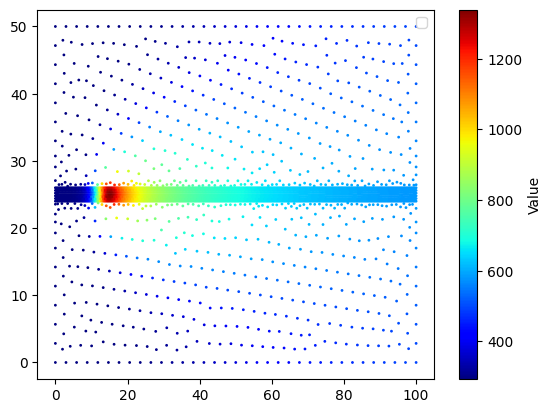

1338.7071620105303
Error after iteration 1 is 68874.40962673888
Error after iteration 2 is 10092.365017862152
Error after iteration 3 is 1468.8508434833775
Error after iteration 4 is 214.30560346367068
Error after iteration 5 is 25.678022277611028
Error after iteration 6 is 4.348242782543639
Error after iteration 7 is 0.5743378541141462
Error after iteration 8 is 0.09468467478704712
Error after iteration 9 is 0.013011126115847394
Error after iteration 10 is 0.002149897193698245
Error after iteration 11 is 0.00029706477611500304
Error after iteration 12 is 5.003159997192639e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error after iteration 13 is 6.8106078132476054e-06
Time Step 8
Sum of K ele 8.205242041370298e-16
Sum of G ele -5.328853677766254e-17
Sum of F ele 62.808570699048765
Sum of Bc ele 0.5


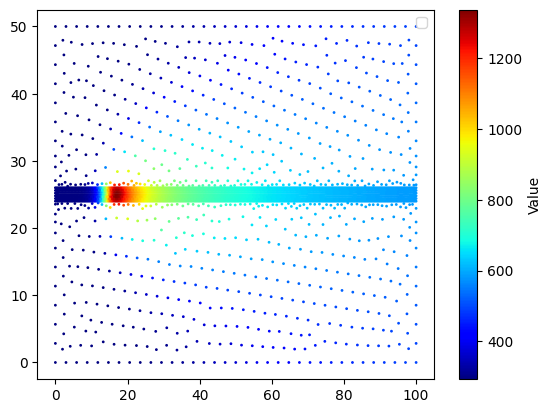

1336.457130150383
Error after iteration 1 is 68738.54610637439
Error after iteration 2 is 10041.766126996785
Error after iteration 3 is 1464.705754467506
Error after iteration 4 is 212.98094872877414
Error after iteration 5 is 25.88615789709981
Error after iteration 6 is 4.288280022290111
Error after iteration 7 is 0.5783231572670545
Error after iteration 8 is 0.09241460619801486
Error after iteration 9 is 0.01308438995419969
Error after iteration 10 is 0.0020829798098314033
Error after iteration 11 is 0.00029868598159871716
Error after iteration 12 is 4.826778702016432e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error after iteration 13 is 6.853338016444183e-06
Time Step 9
Sum of K ele 7.389922007661198e-16
Sum of G ele -3.756760527662273e-17
Sum of F ele 62.81458695027955
Sum of Bc ele 0.5


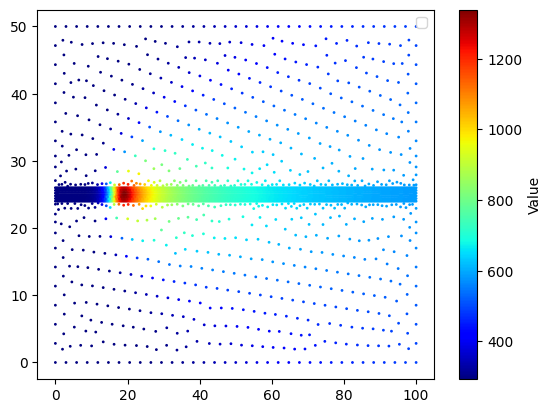

1338.7124699618248
Error after iteration 1 is 68630.92111208719
Error after iteration 2 is 10002.542865808224
Error after iteration 3 is 1460.1897383775613
Error after iteration 4 is 211.06182747913414
Error after iteration 5 is 25.661905443538295
Error after iteration 6 is 4.246289292401534
Error after iteration 7 is 0.577694214663565
Error after iteration 8 is 0.09099443291658063
Error after iteration 9 is 0.013138519263840902
Error after iteration 10 is 0.0020206870532370417
Error after iteration 11 is 0.0003005506197717417
Error after iteration 12 is 4.5851163987605964e-05


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error after iteration 13 is 6.895476313888259e-06
Time Step 10
Sum of K ele 1.7433970933566911e-16
Sum of G ele 2.1521413123837263e-17
Sum of F ele 62.83966718454883
Sum of Bc ele 0.5


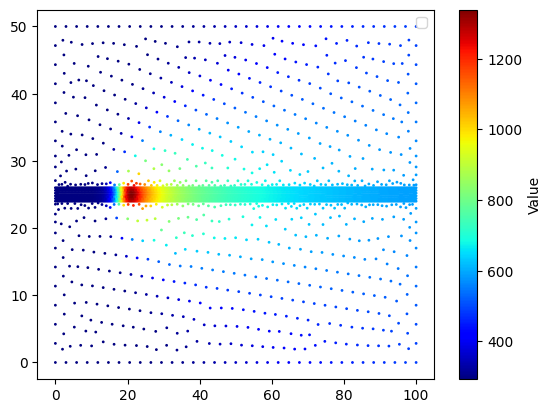

1338.8354052091013


In [32]:
# T,mesh = PicardIterationSparse(meshFactorForEntireSurface = 3,meshFactorForPatchSurface=0.07)
# T,mesh = PicardIterationSparse(meshFactorForEntireSurface = 1.5,meshFactorForPatchSurface=0.5)
T,mesh = PicardIterationSparseForMovingSource(meshFactorForEntireSurface = 3,meshFactorForPatchSurface=.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1339.1137393371687


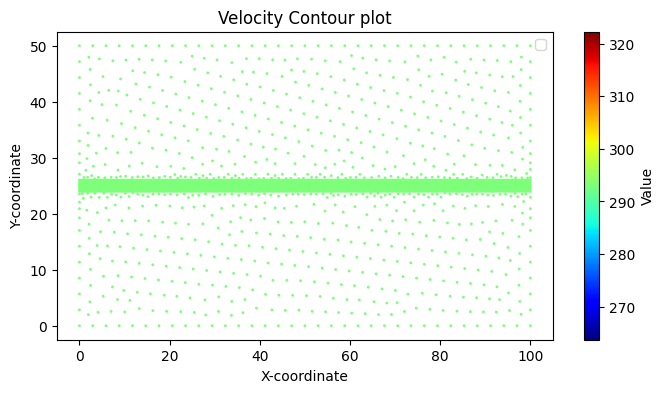

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


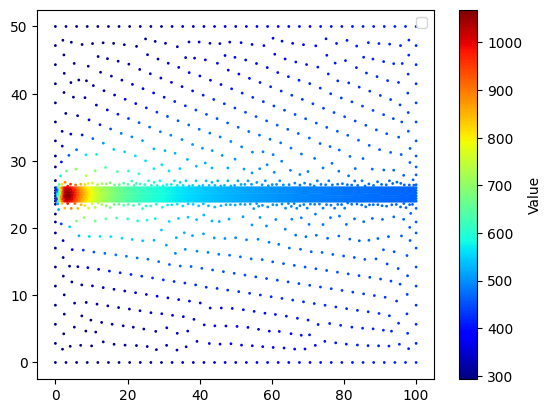

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


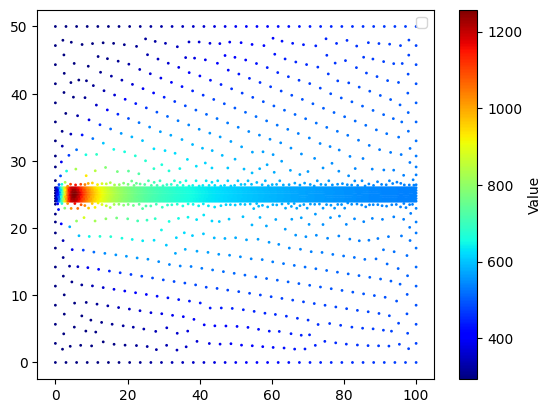

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


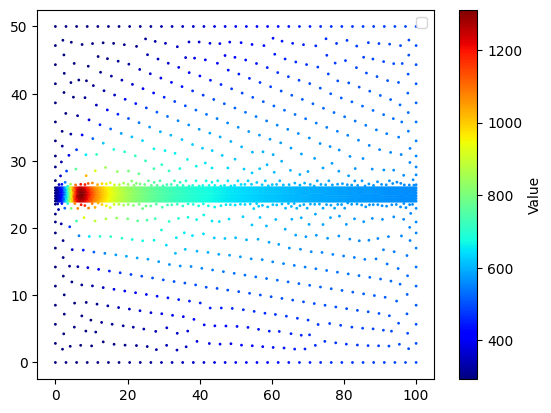

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


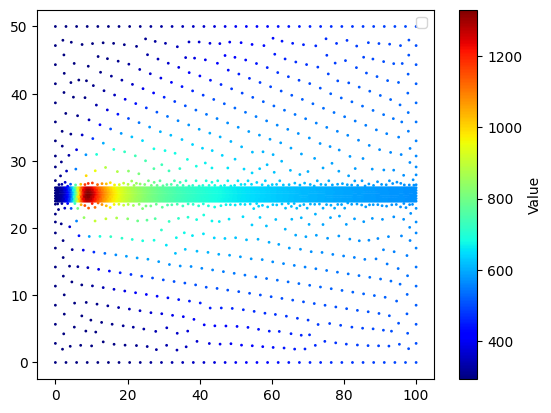

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


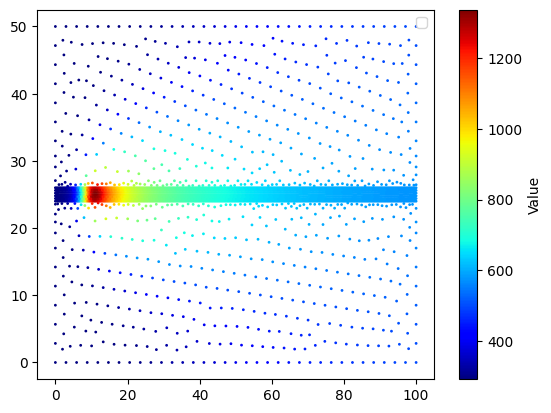

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


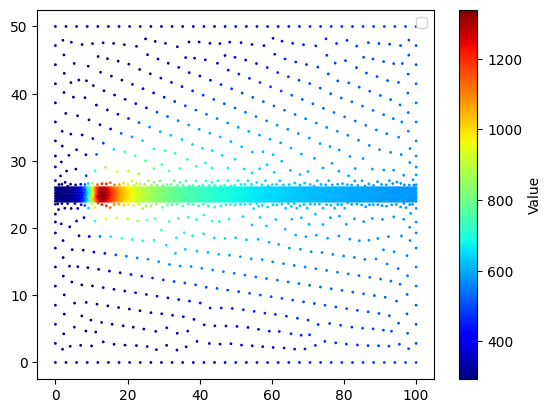

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


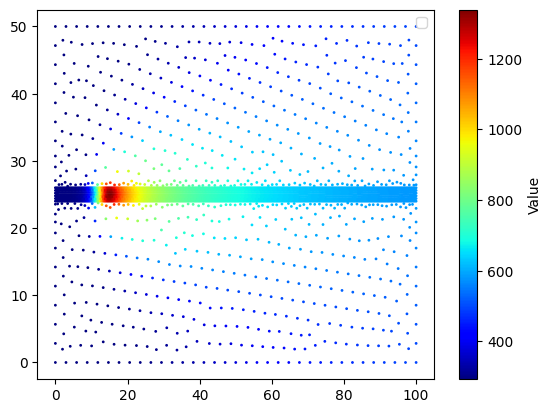

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


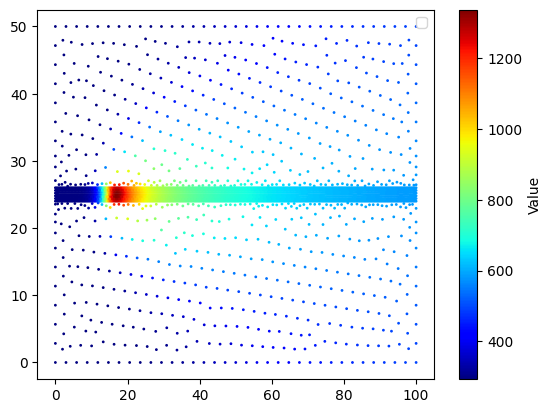

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


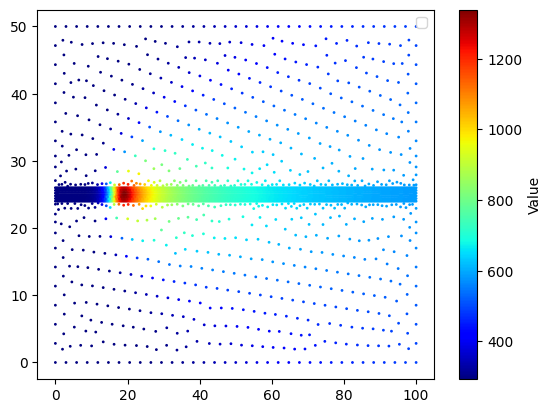

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


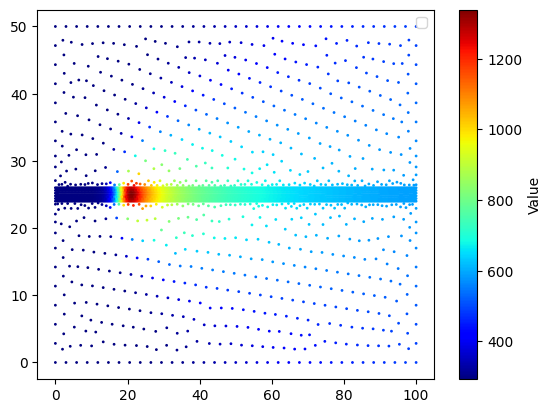

In [33]:
print(np.max(T))
plt.figure(figsize=(8,4))
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Velocity Contour plot')
for timestep in range(T.shape[0]):
    scatter = plt.scatter(mesh.coords[:, 0], mesh.coords[:, 1], c=T[timestep,:], cmap='jet', s=1, edgecolor=None)
    plt.legend()
    plt.colorbar(scatter, label='Value')
    plt.show()

1339.1137393371687


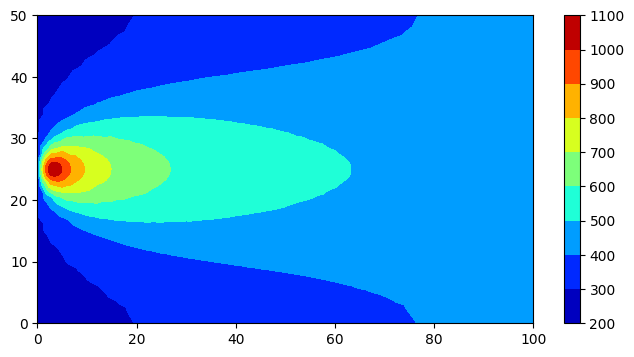

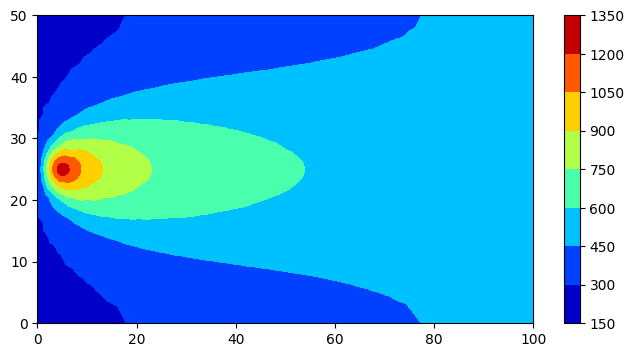

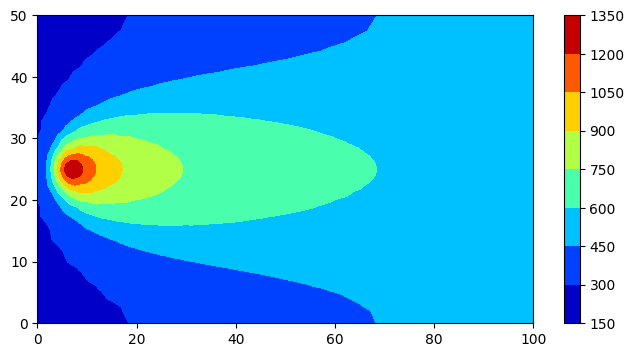

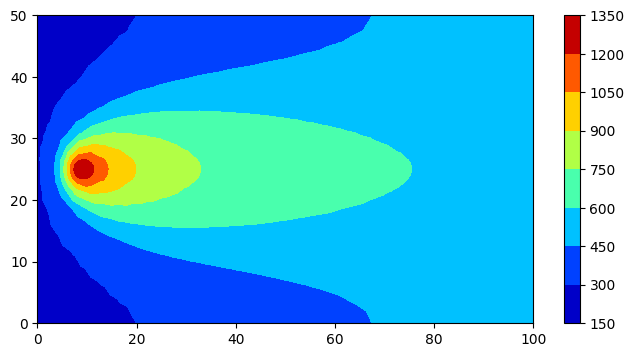

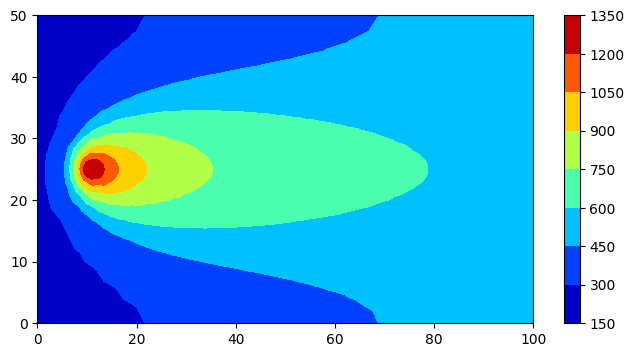

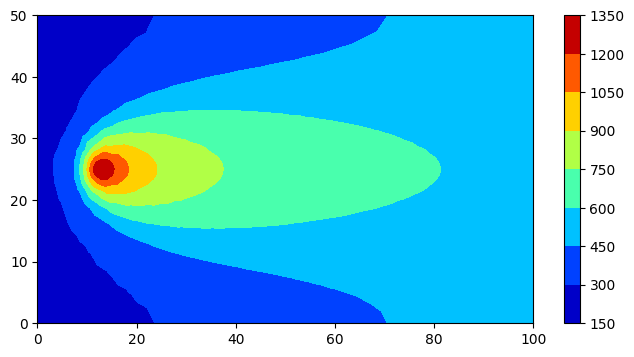

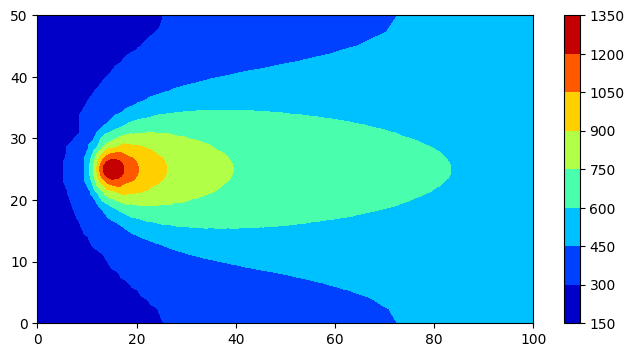

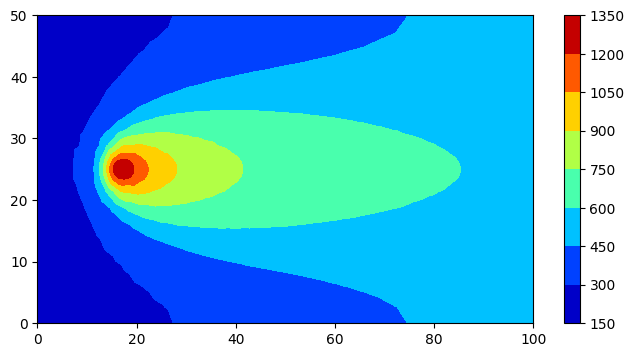

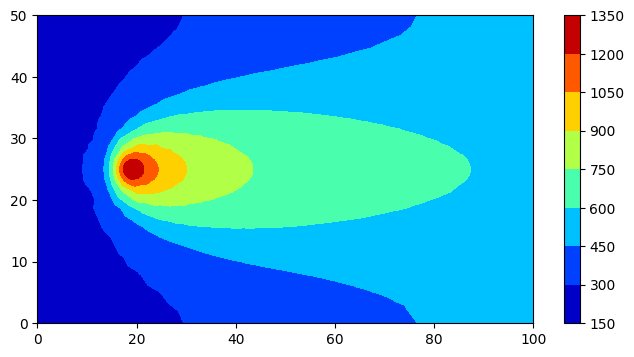

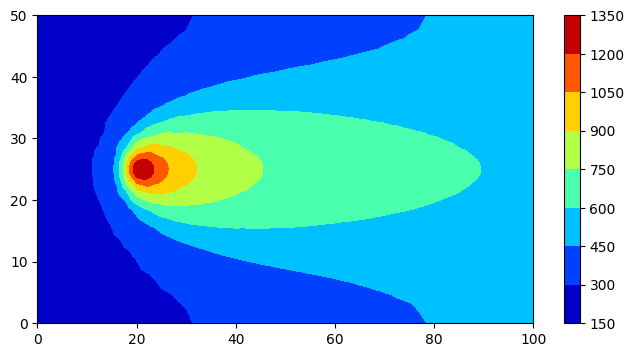

In [34]:
print(np.max(T))
for timestep in range(1,T.shape[0]):
    plt.figure(figsize=(8,4))
    plt.tricontourf(mesh.coords[:, 0], mesh.coords[:, 1],T[timestep,:],cmap='jet')
    plt.colorbar()
    plt.show()

In [35]:
print(np.max(T))

1339.1137393371687


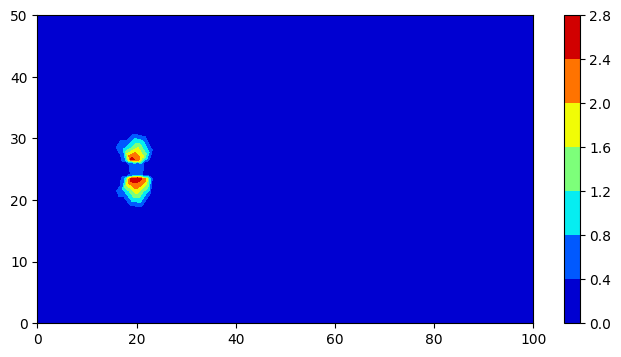

In [36]:
plt.figure(figsize=(8,4))
plt.tricontourf(mesh.coords[:, 0], mesh.coords[:, 1],mesh.S.reshape(-1),cmap='jet')
plt.colorbar()
plt.show()

In [37]:
n = 0
for ele in mesh.triNodesTags:
    n += 1 if np.min(mesh.coords[ele-1,1]) >=24 and np.min(mesh.coords[ele-1,1]) <= 26 else 0
print('Value of H is '+str((100*2/n)**.5)+' in mm')

Value of H is 0.24415675011949203 in mm


In [38]:
T.shape

(11, 2619)

In [39]:
np.where(mesh.coords[:,1]>=24*mesh.coords[:,1]<=26)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
len(mesh.triNodesTags)

28910

## Don't loook at the below code it's not updated with latest implementation

In [ ]:
dn = np.array([1,2,3]).reshape(-1,1)
(dn.T@dn)[0][0]

In [ ]:
mesh = RectangularMesh(mesh_factor=2,geo_file='rectangle.geo')

In [ ]:
A,K,S,Boundary = mesh.A,mesh.K,mesh.S,mesh.Boundary
coords = mesh.coords
dirichiletBoundary = np.where(coords[:,0] == 0)[0]
n = S.shape[0]
nodes = np.arange(n)
dirichiletBoundaryTemperature = 20
Temperature = np.ones((n,1))*dirichiletBoundaryTemperature
interiorNodes = np.delete(nodes,dirichiletBoundary)

In [ ]:
((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])

In [ ]:
F = (A+K)[np.ix_(interiorNodes,interiorNodes)]
Temperature[interiorNodes] = np.linalg.pinv(F)@((S + Boundary - ((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))[interiorNodes])

In [ ]:
np.sum(((A+K)[:,dirichiletBoundary]@(dirichiletBoundaryTemperature*np.ones((len(dirichiletBoundary),1)))))

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Velocity Contour plot')
scatter = plt.scatter(mesh.coords[:, 0], mesh.coords[:, 1], c=Temperature, cmap='jet', s=7, edgecolor=None)
plt.legend()
plt.colorbar(scatter, label='Value')
plt.show()

In [ ]:
np.max(Temperature)

In [ ]:
nodesForAnalysis = np.where(abs(coords[:,1]-20) <= .5)[0]
plt.title('Velcity v/s X-coordinate')
plt.xlabel('X-coordinate')
plt.ylabel('Velocity')
plt.scatter(coords[nodesForAnalysis, 0], Temperature[nodesForAnalysis],s=3)
plt.legend()
plt.show()